<h1>Understanding PyTorch with an example: a step-by-step tutorial</h1>

source: https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e

PyTorch is the fastest growing Deep Learning framework and it is also used by <strong>Fast.ai</strong> in its MOOC, <a href="https://course.fast.ai" target="_blank" rel="noopener"> Deep Learning for Coders</a> and its <a href=" https://docs.fast.ai"  target="_blank" rel="noopener"> library</a>.

PyTorch is also very pythonic, meaning, it feels more natural to use it if you already are a Python developer.

In this notebook, we will first build a simple regression model using scikit-learn. Then we build a simple artificial neural network model using the PyTorch library, to achieve the same. 

Table of Contents

<ol type='I'>
    <li><a href='#section_1'>A Simple Regression Problem</a></li>
    <li><a href='#section_2'>Gradient Descent</a></li>
    <li><a href='#section_3'>Linear Regression in Numpy</a></li>
    <li><a href='#section_4'>PyTorch</a></li>
    <li><a href='#section_5'>Autograd</a></li>
    <li><a href='#section_6'>Dynamic Computation Graph</a></li>
    <li><a href='#section_7'>Optimizer</a></li>
    <li><a href='#section_8'>Loss</a></li>
    <li><a href='#section_9'>Model</a></li>
    <li><a href='#section_10'>Dataset</a></li>
    <li><a href='#section_11'>DataLoader</a></li>
    <li><a href='#section_12'>Evaluation</a></li>
</ol>


<a id='section_1'></a>

    
<h2>A Simple Regression Problem</h2>

Most tutorials start with some nice and pretty image classification problem to illustrate how to use PyTorch. It may seem cool, but I believe it distracts you from the <strong>main goal: how PyTorch works?</strong>

For this reason, in this tutorial, I will stick with a simple and familiar problem: <strong>a linear regression with a single feature x!</strong> It doesn’t get much simpler than that…
<br>

<h3>
    $ y = a + bx + \sigma $ </h3>
            Simple Linear Regression model

    
<h3>Data Generation</h3>

Let’s start <strong>generating</strong> some synthetic data: we start with a vector of 100 points for our <strong>feature</strong> <i>x</i> and create our <strong>labels</strong> using <i>a = 1, b = 2</i> and some Gaussian noise.

Next, let’s <strong>split</strong> our synthetic data into <strong>train</strong> and <strong>validation</strong> sets, shuffling the array of indices and using the first 80 shuffled points for training.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

In [4]:
# Data Generation
np.random.seed(42)
X = np.random.rand(100, 1)
y = 1 + 2 * X + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

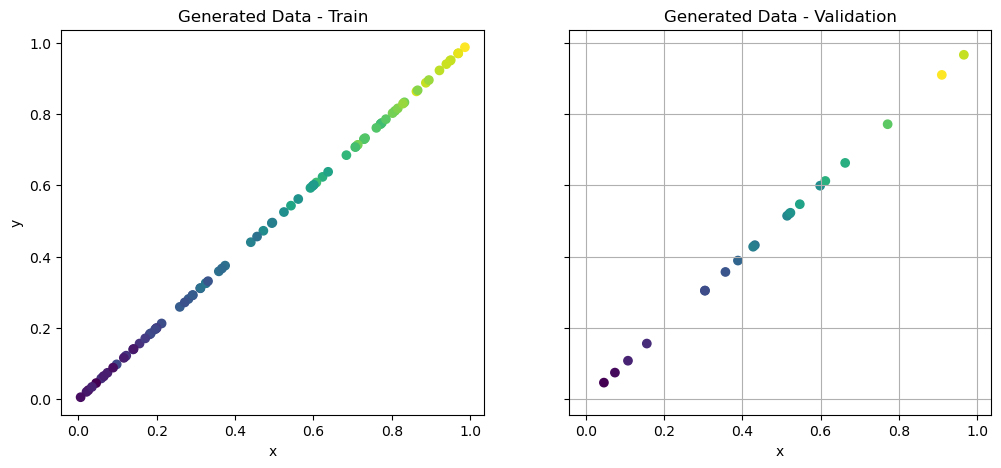

In [8]:
# Visualize the data.
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 5))
train_ax.scatter(X_train, X_train, c=y_train)

train_ax.set_title("Generated Data - Train")
train_ax.set_xlabel("x")
train_ax.set_ylabel("y")

test_ax.scatter(X_val, X_val, c=y_val)
test_ax.set_title("Generated Data - Validation")
test_ax.set_xlabel("x")
train_ax.set_ylabel("y")


plt.grid()
plt.show()

The image above should look like:
<br>
<img width="100%" height="80%" src='pic/train-test-split.webp'/>

We know that a = 1 and b = 2, but now let’s see how close we can get to the true values by using gradient descent and the 80 points in the training set…

<a id='section_2'></a>
<h2> 2. Gradient Descent </h2>

If you are comfortable with the inner workings of gradient descent, feel free to skip this section. It goes beyond the scope of this post to fully explain how gradient descent works, but I’ll cover the four basic steps you’d need to go through to compute it.

### Step 1: Compute the Loss

For a regression problem, the loss is given by the Mean Square Error (MSE), that is, the average of all squared differences between labels (y) and predictions (a + bx).

<a id='section_3'></a>
<h2> 3. Linear Regression in Numpy</h2>

In [10]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

print(a, b)

# Sets learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Computes our model's predicted output
    yhat = a + b * X_train
    
    # How wrong is our model? That's the error! 
    error = (y_train - yhat)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    
    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (X_train * error).mean()
    
    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad
    
print(a, b)

# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(X_train, y_train)
print(linr.intercept_, linr.coef_[0])

[0.49671415] [-0.1382643]
[1.02354094] [1.96896411]
[1.02354075] [1.96896447]


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(X_train), type(X_train_tensor), X_train_tensor.type())

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [11]:
# FIRST
# Initializes parameters "a" and "b" randomly, ALMOST as we did in Numpy
# since we want to apply gradient descent on these parameters, we need
# to set REQUIRES_GRAD = TRUE
a = torch.randn(1, requires_grad=True, dtype=torch.float)
b = torch.randn(1, requires_grad=True, dtype=torch.float)
print(a, b)

# SECOND
# But what if we want to run it on a GPU? We could just send them to device, right?
a = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print(a, b)
# Sorry, but NO! The to(device) "shadows" the gradient...

# THIRD
# We can either create regular tensors and send them to the device (as we did with our data)
a = torch.randn(1, dtype=torch.float).to(device)
b = torch.randn(1, dtype=torch.float).to(device)
# and THEN set them as requiring gradients...
a.requires_grad_()
b.requires_grad_()
print(a, b)

tensor([0.1186], requires_grad=True) tensor([-2.5126], requires_grad=True)
tensor([0.2089], requires_grad=True) tensor([0.6187], requires_grad=True)
tensor([-1.6070], requires_grad=True) tensor([-1.2715], requires_grad=True)


In [12]:
# We can specify the device at the moment of creation - RECOMMENDED!
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


In [13]:
lr = 1e-1
n_epochs = 1000

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients! 
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()
    
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    # Let's check the computed gradients...
    print(a.grad)
    print(b.grad)
    
    # What about UPDATING the parameters? Not so fast...
    
    # FIRST ATTEMPT
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # a = a - lr * a.grad
    # b = b - lr * b.grad
    # print(a)

    # SECOND ATTEMPT
    # RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
    # a -= lr * a.grad
    # b -= lr * b.grad        
    
    # THIRD ATTEMPT
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()
    
print(a, b)

tensor([-3.1125])
tensor([-1.8156])
tensor([-2.3184])
tensor([-1.4064])
tensor([-1.7219])
tensor([-1.0982])
tensor([-1.2737])
tensor([-0.8659])
tensor([-0.9372])
tensor([-0.6906])
tensor([-0.6845])
tensor([-0.5583])
tensor([-0.4948])
tensor([-0.4582])
tensor([-0.3526])
tensor([-0.3824])
tensor([-0.2459])
tensor([-0.3248])
tensor([-0.1660])
tensor([-0.2810])
tensor([-0.1063])
tensor([-0.2475])
tensor([-0.0616])
tensor([-0.2218])
tensor([-0.0283])
tensor([-0.2019])
tensor([-0.0036])
tensor([-0.1864])
tensor([0.0147])
tensor([-0.1743])
tensor([0.0283])
tensor([-0.1646])
tensor([0.0382])
tensor([-0.1568])
tensor([0.0453])
tensor([-0.1505])
tensor([0.0505])
tensor([-0.1452])
tensor([0.0541])
tensor([-0.1408])
tensor([0.0566])
tensor([-0.1370])
tensor([0.0582])
tensor([-0.1337])
tensor([0.0592])
tensor([-0.1307])
tensor([0.0597])
tensor([-0.1280])
tensor([0.0599])
tensor([-0.1255])
tensor([0.0598])
tensor([-0.1232])
tensor([0.0594])
tensor([-0.1211])
tensor([0.0590])
tensor([-0.1190])
tensor

In [14]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()

In [15]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()    
    
    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


In [16]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


In [17]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x

In [18]:
torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # What is this?!?
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('a', tensor([0.3367])), ('b', tensor([0.1288]))])
OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


In [19]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

In [20]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# Checks model's parameters
print(model.state_dict())

OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


In [21]:
from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))
(tensor([0.7713]), tensor([2.4745]))


In [22]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

In [23]:
losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
print(model.state_dict())

OrderedDict([('a', tensor([1.0254])), ('b', tensor([1.9693]))])


In [24]:
from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

In [25]:
losses = []
val_losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

print(model.state_dict())

OrderedDict([('a', tensor([1.0196])), ('b', tensor([1.9666]))])
